# Inferential statistics II - Bootstrapping

## Introduction

In the previous frequentist mini-projects, you did frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th-Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold for the particular case you're working on, and what you want to do has a known theoretical distribution (for example the mean of a sampling distribution that we looked at in the previous mini-project.)

In this mini-project, you'll use the same medical charge data you used in the frequentist inference mini-project, but this time you'll make inferences about the population using bootstrapping (ie. simulating repeated re-runs of an experiment.) If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

While these exercises do not strictly depend on these concepts, we encourage you to complete the previous mini-projects before starting this one so that you can approach this assignment with a good understanding of frequentist concepts like:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete mini-project, it's important that you first complete the bootstrap resources listed in this subunit, as they contain valuable information about how to calculate bootstrap replicates of summary statistics. Having an basic understanding of what confidence intervals and p-values are will also be helpful (we touch on them in this mini-project, but please speak to your mentor or conduct individual research if you'd like to learn more.) 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()
from functools import partial
from scipy.stats import norm

## Medical charge data set

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you'll now use bootstrap inference to verify your calculations and check that you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

In [4]:
np.random.seed(47)
N_rep = 10000

In [5]:
# make function that generates bootstrap replicates from sample replicates
def gen_bs_reps(data, func, size=1):
    """Generate bootstrap replicates from various test statistics """
    # initailize boostrap array
    bs_reps = np.empty(size)
    # add degrees of freedom parameter if np.std is given function
    if func == np.std:
        func = partial(func, ddof=1)
    for i in range(size):
        # generate replicates from bootstrap samples
        bs_reps[i] = func(np.random.choice(data, len(data)))
    return bs_reps

In [6]:
# generate bootstrap replicates of means of all medical charges
bs_reps = gen_bs_reps(med_charges.charges, np.mean, N_rep)
bs_reps[:4]

array([13386.79887534, 13227.45279065, 13445.33945215, 13474.93585142])

In [7]:
# find 95% confidence interval of the bootstrap replicates
ci_95 = np.percentile(bs_reps, [5, 95])
# show the bound of interest
print('The relevant 95% confidence interval of the mean is {}.'
      .format(format(ci_95[0], '.2f')))

The relevant 95% confidence interval of the mean is 12724.47.


If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember, in the previous mini-projects, we saw that there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__ Null Hypothesis: Any observed difference between the standard deviations of the charges to each population is not reliably different from zero, but due to chance.<br>
Alternative Hypothesis: Any observed difference between the standard deviations of the charges to each population is reliable.

Create the two sample arrays and observe the respective sample sizes of each population.

In [8]:
pop_uninsured = med_charges.charges[med_charges.insuranceclaim == 0]
pop_uninsured.count()

555

In [9]:
pop_insured = med_charges.charges[med_charges.insuranceclaim == 1]
pop_insured.count()

783

In [10]:
# make function to create ECDF
def ecdf(data):
    """Compute Empirical Cumulative Distribution Function for a 1-D array of measurements"""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

In [11]:
# call ECDF function
x_uninsured, y_uninsured = ecdf(pop_uninsured)
x_insured, y_insured = ecdf(pop_insured)

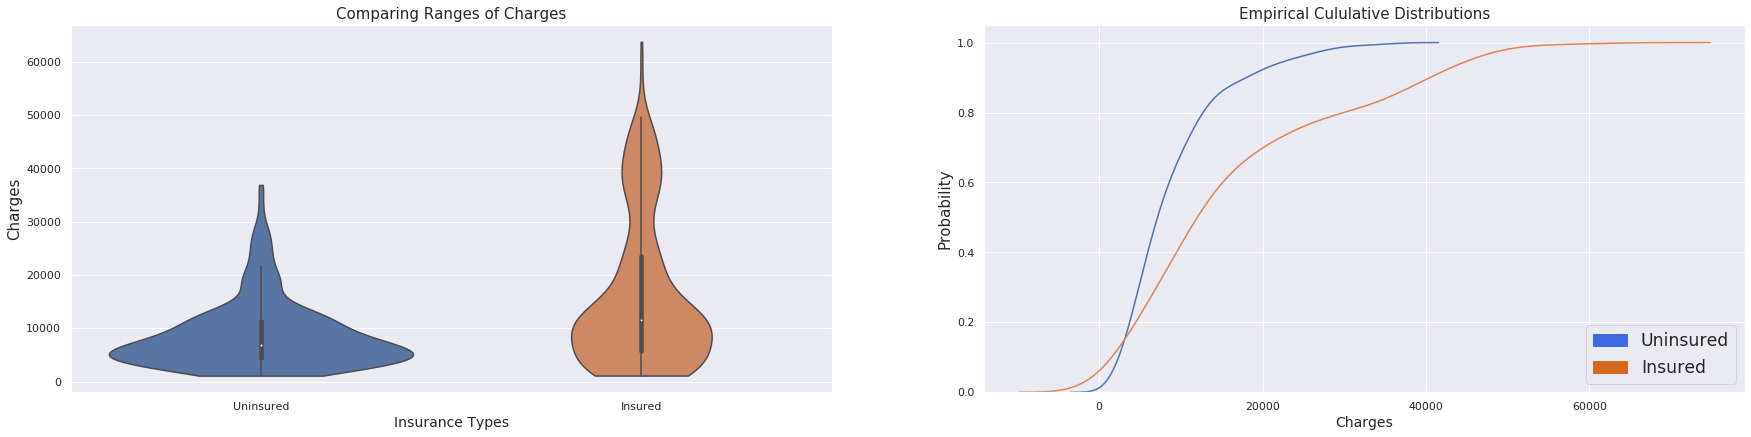

In [12]:
# make violin plot to observe probability density and quartiles
plt.subplot(1,2,1)

sns.violinplot(x=med_charges.insuranceclaim, y=med_charges.charges, data=med_charges, cut=0);

x = np.arange(2)
plt.xticks(x, ('Uninsured', 'Insured'))

plt.title('Comparing Ranges of Charges', fontsize=15);
plt.xlabel('Insurance Types', fontsize=14);
plt.ylabel('Charges', fontsize=15);

# make distribution plot to observe cumulative distribution function
plt.subplot(1,2,2)

# eliminate divide by zero error
np.seterr(divide='ignore', invalid='ignore')

kwargs = {'cumulative': True}
sns.distplot(x_uninsured, y_uninsured, kde_kws=kwargs);
sns.distplot(x_insured, y_insured, kde_kws=kwargs);

plt.title('Empirical Cululative Distributions', fontsize=15);
plt.xlabel('Charges', fontsize=14);
plt.ylabel('Probability', fontsize=15);

# add legend identifying insurance type
uninsured_patch = mpatches.Patch(color='royalblue', label='Uninsured')
insured_patch = mpatches.Patch(color='chocolate', label='Insured')
plt.legend(handles=[uninsured_patch, insured_patch], fontsize='x-large')

plt.subplots_adjust(right=4, top=1.4)

The distributions appear distinct.

Generate the bootstrap replicates of the standard deviations of the medical charges for each group.

In [13]:
bs_reps_uninsured = gen_bs_reps(pop_uninsured, np.std, N_rep)
bs_reps_uninsured[:4]

array([6798.86882366, 6178.03568715, 6227.24386535, 6218.47312312])

In [14]:
bs_reps_insured = gen_bs_reps(pop_insured, np.std, N_rep)
bs_reps_insured[:4]

array([14240.54859913, 13875.88746368, 13943.69639337, 13826.67324021])

In [15]:
# get differences between bootstrap replicates pairwise
bs_reps_diff = bs_reps_insured - bs_reps_uninsured
bs_reps_diff[:4]

array([7441.67977547, 7697.85177653, 7716.45252802, 7608.2001171 ])

In [16]:
# obtain confidence interval for differences between bootstrap replicates
ci_95_diff = np.percentile(bs_reps_diff, [2.5, 97.5])
print('The 95% confidence interval of the standard deviation is ({}, {}).'
      .format(format(ci_95_diff[0], '.2f'), (format(ci_95_diff[1], '.2f'))))

The 95% confidence interval of the standard deviation is (6676.64, 8490.44).


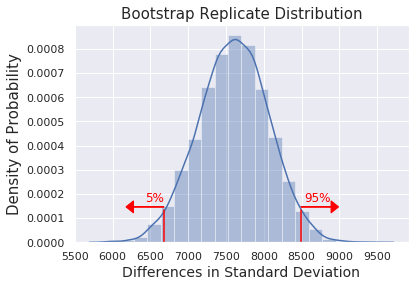

In [17]:
# plot distribution of bootstrap replicates
sns.distplot(bs_reps_diff, bins=20);

# plot and label lower bound
plt.axvline(x=ci_95_diff[0], ymax=np.e ** (-0.5 * norm.ppf(.975) ** 2), color='red');
plt.arrow(ci_95_diff[0], np.e ** (-0.5 * norm.ppf(.975) ** 2) / 1000, -500, 0, 
          width=0.000003, length_includes_head=True, head_width=0.00005, head_length=100, color='red');
plt.text(ci_95_diff[0] - 250, 0.00017,'5%', color='red');

# plot and label upper bound
plt.axvline(x=ci_95_diff[1], ymax=np.e ** (-0.5 * norm.ppf(.975) ** 2), color='red');
plt.arrow(ci_95_diff[1], np.e ** (-0.5 * norm.ppf(.975) ** 2) / 1000, 500, 0, 
          width=0.000003, length_includes_head=True, head_width=0.00005, head_length=100, color='red');
plt.text(ci_95_diff[1] + 50, 0.00017,'95%', color='red');

plt.title('Bootstrap Replicate Distribution', fontsize=15);
plt.xlabel('Differences in Standard Deviation', fontsize=14);
plt.ylabel('Density of Probability', fontsize=15);

The value specified to test for the null hypothesis is zero. Since zero is not a value in the 95% confidence interval, it is rejected as a plausible value and a test of the null hypothesis at the 0.05 level. Therefore, the null hypothesis should be rejected at this level. This leaves the alternate hypothesis. It is plausible that the difference between the standard deviations of the uninsured and the insured claim charges is significantly different from zero at the 0.05 level.

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type I error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this, this time using the bootstrap approach.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__ Null Hypothesis: Any observed difference between the means of the charges to each population is not reliably different from zero, but due to chance.<br>
Alternative Hypothesis: Any observed difference between the means of the charges to each population is reliable.

The null hypothesis requires that the means of both samples are equal. To simulate this both arrays must be shifted until they have the same mean.

In [18]:
pop_uninsured_shifted = pop_uninsured - np.mean(pop_uninsured) + np.mean(med_charges.charges)

In [19]:
pop_insured_shifted = pop_insured - np.mean(pop_insured) + np.mean(med_charges.charges)

Generate the bootstrap replicates of the means of the medical charges for each shifted group.

In [20]:
bs_reps_mean_uninsured = gen_bs_reps(pop_uninsured_shifted, np.mean, N_rep)
bs_reps_mean_uninsured[:4]

array([13234.13104073, 13838.40014228, 13876.71095851, 13323.36582653])

In [21]:
bs_reps_mean_insured = gen_bs_reps(pop_insured_shifted, np.mean, N_rep)
bs_reps_mean_insured[:4]

array([13110.02733222, 14099.24710481, 13190.96436886, 12423.20316967])

In [22]:
# get differences between shifted bootstrap replicates pairwise
bs_reps_mean_diff = bs_reps_mean_insured - bs_reps_mean_uninsured
bs_reps_mean_diff[:4]

array([-124.10370851,  260.84696253, -685.74658965, -900.16265686])

In [23]:
# observed difference of means
emperical_diff_means = np.mean(pop_insured) - np.mean(pop_uninsured)
emperical_diff_means

7602.506384231372

In [24]:
# find likelihood, under null hypothesis, to get an outcome at least as extreme as the observed difference of means
p_val = np.sum(bs_reps_mean_diff >= emperical_diff_means)/len(bs_reps_mean_diff)
p_val

0.0

There was not one instance in 10,000 samples that were as extreme as the observed difference of the means. Since this is less than the 5% significance level, the null hypothesis should be rejected.

__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

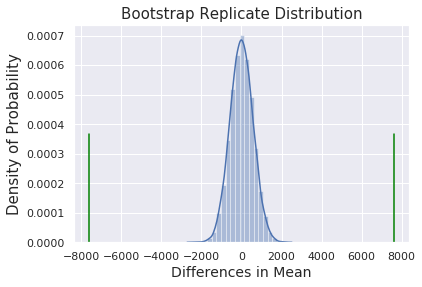

In [25]:
sns.distplot(bs_reps_mean_diff, bins=20);
plt.axvline(x=emperical_diff_means, ymax=0.5, color='green');
plt.axvline(x=-emperical_diff_means, ymax=0.5, color='green');

plt.title('Bootstrap Replicate Distribution', fontsize=15);
plt.xlabel('Differences in Mean', fontsize=14);
plt.ylabel('Density of Probability', fontsize=15);

__A:__ The order of operands in the equation for the observed difference of the means could have been reversed, which would have resulted in that value being on the other side of the target value of the null hypothesis (zero).
For this two-sided hypothesis test, the difference from zero where any one of the bootstrap replicates lands is what is being tested. Both sides are counted.

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__ Seeing as the module drew over a nonillion samples before finding one as extreme as the observed difference of the means, I'll pass on trying to observe one.

__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__ From the hypothesis testing done on the difference of the standard deviations (square root of variance), it is plausible that the difference between the standard deviations of the uninsured and the insured claim charges is significantly different from zero at the 0.05 level. With this in mind, a Welch's t-test should still be used.

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

__A:__ The question only states what is not being asked by the team. It does not ask what they are looking to find.<br>
Assuming the ad-recommender team believes the new algorithm will not perform worse than the old one performs and wants to know whether or not algrithm B's click-through rate performed better than that of algorithm A, a one-sided test should be performed.<br>
A permutation bootstrap hypothesis test for the difference of the mean can be performed.<br>
Null hypothesis: The difference of the means of algorithm A and algrithm B is zero. The redesign has no significant effect.<br>
Alternate hypothesis: The difference of the means of algorithm A and algorithm B is not zero. The mean of algorithm B is significantly greater than the mean of algorithm A. It performs better.<br>
The real world consequence of rejecting the null hypothesis would be to decide if keeping the new algorithm would be worth the cost of impementing it. A break-even click-through rate should be determined and simulated as the new null hypothesis to help decide if the new algorithm would be profitable to use.

Now, if the ad-recommender team has not ruled out the possibility that the new algorithm may perform worse than the old one performs, a two-sided test should be performed to determine this possibility.<br>
A two-sample bootstrap hypothesis test for the difference of the mean can be performed as was done above.<br>
Null hypothesis: The difference of the means of algorithm A and algrithm B is zero.<br>
Alternate hypothesis: The difference of the means of algorithm A and algorithm B is not zero. The difference is statistically significant. The redesign has no significant effect<br>
A 95% confidence interval of the difference of the means will show the direction of the effect of using the new algorithm over the old one. All values in the confidence interval will be either positive or negative, which specifies the direction of the change in click-through rates. Positive values would give us the same situation as posed above.<br>
If the values in the confidence interval are all negative, the real world consequence of rejecting the null hypothesis would be to decide if a redesign of the new algorithm is cost effective or if it should be scrapped.<br>

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have:
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.